# **Using Independent Distribution to build a Naive Bayes classifier**

## 📑 Table of Contents

- **1. [Setup and Imports](#1-setup-and-imports)**
- **2. [Data Loading and Initial Exploration](#2-data-loading-and-initial-exploration)**
- **3. [Dataset Structure Analysis](#3-dataset-structure-analysis)**
- **4. [Sample Document Exploration](#4-sample-document-exploration)**
- **5. [Text Preprocessing with CountVectorizer](#5-text-preprocessing-with-countvectorizer)**
- **6. [Vocabulary Analysis and Verification](#6-vocabulary-analysis-and-verification)**
- **7. [Naive Bayes Parameter Estimation](#7-naive-bayes-parameter-estimation)**
- **8. [Most Probable Words Analysis](#8-most-probable-words-analysis)**
- **9. [Visualization - Class Distribution and Word Probabilities](#9-visualization---class-distribution-and-word-probabilities)**
- **10. [TensorFlow Probability Distribution Creation](#10-tensorflow-probability-distribution-creation)**
- **11. [Sampling and Generation](#11-sampling-and-generation)**
- **12. [Sample Quality Analysis and Visualization](#12-sample-quality-analysis-and-visualization)**
- **13. [Model Summary and Performance Insights](#13-model-summary-and-performance-insights)**


## 1. **Setup and Imports**

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# TensorFlow Probability distributions
tfd = tfp.distributions

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")




✅ All libraries imported successfully!
NumPy version: 2.3.3
TensorFlow Probability version: 0.25.0


## 2. **Data Loading and Initial Exploration**

In [2]:
# Define data path
path = "_data/newsgroup_data/20news-bydate_py3.pkz"

# Load the 20 newsgroups training dataset
print("📊 Loading 20 Newsgroups dataset...")
newsgroups_data = fetch_20newsgroups(data_home=path, subset='train')

# Display dataset information
print("\n" + "="*60)
print("DATASET DESCRIPTION:")
print("="*60)
print(newsgroups_data['DESCR'])

📊 Loading 20 Newsgroups dataset...

DATASET DESCRIPTION:
.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samp

## 3. **Dataset Structure Analysis**

In [3]:
# Analyze dataset structure
n_documents = len(newsgroups_data['data'])
n_classes = len(newsgroups_data['target_names'])

print(f"📈 Dataset Statistics:")
print(f"   • Total documents: {n_documents:,}")
print(f"   • Number of classes: {n_classes}")
print(f"   • Class names: {len(newsgroups_data['target_names'])} categories")

# Display class distribution
class_counts = Counter(newsgroups_data['target'])
class_distribution = pd.DataFrame({
    'Class': [newsgroups_data['target_names'][i] for i in range(n_classes)],
    'Count': [class_counts[i] for i in range(n_classes)]
})

print(f"\n📊 Class Distribution:")
print(class_distribution.to_string(index=False))

📈 Dataset Statistics:
   • Total documents: 11,314
   • Number of classes: 20
   • Class names: 20 categories

📊 Class Distribution:
                   Class  Count
             alt.atheism    480
           comp.graphics    584
 comp.os.ms-windows.misc    591
comp.sys.ibm.pc.hardware    590
   comp.sys.mac.hardware    578
          comp.windows.x    593
            misc.forsale    585
               rec.autos    594
         rec.motorcycles    598
      rec.sport.baseball    597
        rec.sport.hockey    600
               sci.crypt    595
         sci.electronics    591
                 sci.med    594
               sci.space    593
  soc.religion.christian    599
      talk.politics.guns    546
   talk.politics.mideast    564
      talk.politics.misc    465
      talk.religion.misc    377


## 4. **Sample Document Exploration**

In [4]:
# Display sample document and its label
print("📄 SAMPLE DOCUMENT (Index 0):")
print("="*50)
print(newsgroups_data['data'][0])
print("\n" + "="*50)

# Show associated label information
target_label = newsgroups_data['target'][0]
class_name = newsgroups_data['target_names'][target_label]

print(f"🏷️ Document Label Information:")
print(f"  -> Numeric label: {target_label}")
print(f"  -> Class name: {class_name}")
print(f"  -> Example of class 7: {newsgroups_data['target_names'][7]}")

📄 SAMPLE DOCUMENT (Index 0):
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






🏷️ Document Label Information:
  -> Numeric label: 7
  -> Class name: rec.autos
  -> Example of class 7: rec.autos


## 5. **Text Preprocessing with CountVectorizer**

In [5]:
# Initialize CountVectorizer with preprocessing parameters
print("🔧 Preprocessing text data...")

# Parameters explanation:
# - binary=True: Use binary occurrence (0/1) instead of counts
# - max_df=0.25: Ignore words appearing in >25% of documents (too common)
# - min_df=1.01/n_documents: Words must appear in at least 2 documents

count_vectorizer = CountVectorizer(
    input='content',
    binary=True,                    # Binary bag-of-words representation
    max_df=0.25,                   # Ignore overly common words
    min_df=1.01/n_documents        # Ignore rare words (appear only once)
)

# Transform documents to binary bag-of-words matrix
binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_data['data'])

print(f"✅ Text preprocessing completed!")
print(f"  -> Original documents: {n_documents:,}")
print(f"  -> Vocabulary size: {binary_bag_of_words.shape[1]:,} words")
print(f"  -> Matrix shape: {binary_bag_of_words.shape}")
print(f"  -> Matrix sparsity: {(1 - binary_bag_of_words.nnz / np.prod(binary_bag_of_words.shape))*100:.2f}%")


🔧 Preprocessing text data...
✅ Text preprocessing completed!
  -> Original documents: 11,314
  -> Vocabulary size: 56,365 words
  -> Matrix shape: (11314, 56365)
  -> Matrix sparsity: 99.79%


## 6. **Vocabulary Analysis and Verification**

In [6]:
# Verify the vectorization process
print("🔍 Vocabulary Analysis:")

# Check inverse transform for first document
original_words = count_vectorizer.inverse_transform(binary_bag_of_words[0, :])
print(f" -> Words in first document: {len(original_words[0])} unique terms")
print(f" -> Sample words: {list(original_words[0])[:10]}")

# Create inverse vocabulary mapping for later use
inv_vocabulary = {value: key for key, value in count_vectorizer.vocabulary_.items()}
print(f" -> Vocabulary mapping created: {len(inv_vocabulary)} terms")

# Display some vocabulary statistics
word_frequencies = np.array(binary_bag_of_words.sum(axis=0)).flatten()
print(f" -> Most frequent word appears in: {word_frequencies.max()} documents")
print(f" -> Average word frequency: {word_frequencies.mean():.2f} documents")

🔍 Vocabulary Analysis:
 -> Words in first document: 55 unique terms
 -> Sample words: [np.str_('lerxst'), np.str_('wam'), np.str_('umd'), np.str_('where'), np.str_('thing'), np.str_('car'), np.str_('rac3'), np.str_('maryland'), np.str_('college'), np.str_('park')]
 -> Vocabulary mapping created: 56365 terms
 -> Most frequent word appears in: 2717 documents
 -> Average word frequency: 23.43 documents


## 7. **Naive Bayes Parameter Estimation**

**Naive Bayes classifier**

Each feature vector $x$ is a list of indicators for whether a word appears in the article. $x_i$ is 1 if the $i$th word appears, and 0 otherwise. `inv_vocabulary` matches word indices $i$ to words.

Each label $y$ is a value in $0, 1, \ldots, 19$.

The parts of a naive Bayes classifier for this problem can be summarised as:  


- A probability distribution for the feature vector by class, $p(x|y = j)$ for each $j = 0, 1, \ldots, 19$. These probability distributions are assumed to have independent components: we can factorize the joint probability as a product of marginal probabilities
\begin{equation}
    p(x|y = j) = \prod_{i=1}^d p(x_i|y = j)
\end{equation}
These marginal probability distributions are Bernoulli distributions, each of which has a single parameter $\theta_{ji} := p(x_i = 1|y = j)$. This parameter is the probability of observing word $i$ in an article of class $j$. 

- We will use the Laplace smoothed maximum likelihood estimate to compute these parameters. Laplace smoothing involves adding small counts to every feature for each class. Else, if a feature did not appear in the training set of a class, but then we observed it in our test data the log probability would be undefined.

- A collection of class prior probabilities $p(y = j)$. These will be set by computing the class base rates in the training set.  


- A function for computing the probability of class membership via Bayes' theorem:  

\begin{equation}
    p(y = j|x) = \frac{p(x|y = j)p(y = j)}{p(x)}
\end{equation}

In [7]:
# Compute Naive Bayes parameters using Maximum Likelihood Estimation
print("🧮 Computing Naive Bayes Parameters...")

# Initialize parameters
n_classes = newsgroups_data['target'].max() + 1
y = newsgroups_data['target']
n_words = binary_bag_of_words.shape[1]
alpha = 1e-6  # Laplace smoothing parameter (small value for numerical stability)

# Parameter matrix: theta[class][word] = P(word|class)
theta = np.zeros([n_classes, n_words])

print(f" -> Number of classes: {n_classes}")
print(f" -> Vocabulary size: {n_words:,}")
print(f" -> Smoothing parameter (alpha): {alpha}")

# Compute parameters for each class
for c_k in range(n_classes):
    # Create mask for documents belonging to class c_k
    class_mask = (y == c_k)
    N = class_mask.sum()  # Number of documents in this class
    
    # Calculate P(word|class) with Laplace smoothing
    # Formula: (count + alpha) / (total_docs_in_class + alpha*2)
    word_counts = binary_bag_of_words[class_mask, :].sum(axis=0)
    theta[c_k, :] = (word_counts + alpha) / (N + alpha * 2)
    
    if c_k % 5 == 0:  # Progress indicator
        print(f" -> Processed class {c_k}: {newsgroups_data['target_names'][c_k]} ({N} documents)")

print("✅ Parameter estimation completed!")

🧮 Computing Naive Bayes Parameters...
 -> Number of classes: 20
 -> Vocabulary size: 56,365
 -> Smoothing parameter (alpha): 1e-06
 -> Processed class 0: alt.atheism (480 documents)
 -> Processed class 5: comp.windows.x (593 documents)
 -> Processed class 10: rec.sport.hockey (600 documents)
 -> Processed class 15: soc.religion.christian (599 documents)
✅ Parameter estimation completed!


## 8. **Most Probable Words Analysis**

In [8]:
# Analyze the most probable words for each class
print("📊 Most Probable Words by Class:")
print("="*60)

most_probable_word_ix = theta.argmax(axis=1)

# Display results in a structured format
for j, ix in enumerate(most_probable_word_ix):
    class_name = newsgroups_data['target_names'][j]
    most_probable_word = inv_vocabulary[ix]
    probability = theta[j, ix]
    
    print(f"{j:2d}. {class_name:<25} → '{most_probable_word}' ({probability:.4f})")

print("\n💡 These words represent the most characteristic terms for each newsgroup category.")

📊 Most Probable Words by Class:
 0. alt.atheism               → 'people' (0.4104)
 1. comp.graphics             → 'graphics' (0.3493)
 2. comp.os.ms-windows.misc   → 'windows' (0.6802)
 3. comp.sys.ibm.pc.hardware  → 'thanks' (0.3458)
 4. comp.sys.mac.hardware     → 'mac' (0.3668)
 5. comp.windows.x            → 'window' (0.3153)
 6. misc.forsale              → 'sale' (0.6120)
 7. rec.autos                 → 'car' (0.5471)
 8. rec.motorcycles           → 'dod' (0.5318)
 9. rec.sport.baseball        → 'he' (0.4724)
10. rec.sport.hockey          → 'ca' (0.4483)
11. sci.crypt                 → 'clipper' (0.5277)
12. sci.electronics           → 'use' (0.3570)
13. sci.med                   → 'reply' (0.3215)
14. sci.space                 → 'space' (0.5312)
15. soc.religion.christian    → 'god' (0.5743)
16. talk.politics.guns        → 'people' (0.4652)
17. talk.politics.mideast     → 'people' (0.4894)
18. talk.politics.misc        → 'people' (0.4925)
19. talk.religion.misc        → 'he' (0.4

## 9. **Visualization - Class Distribution and Word Probabilities**

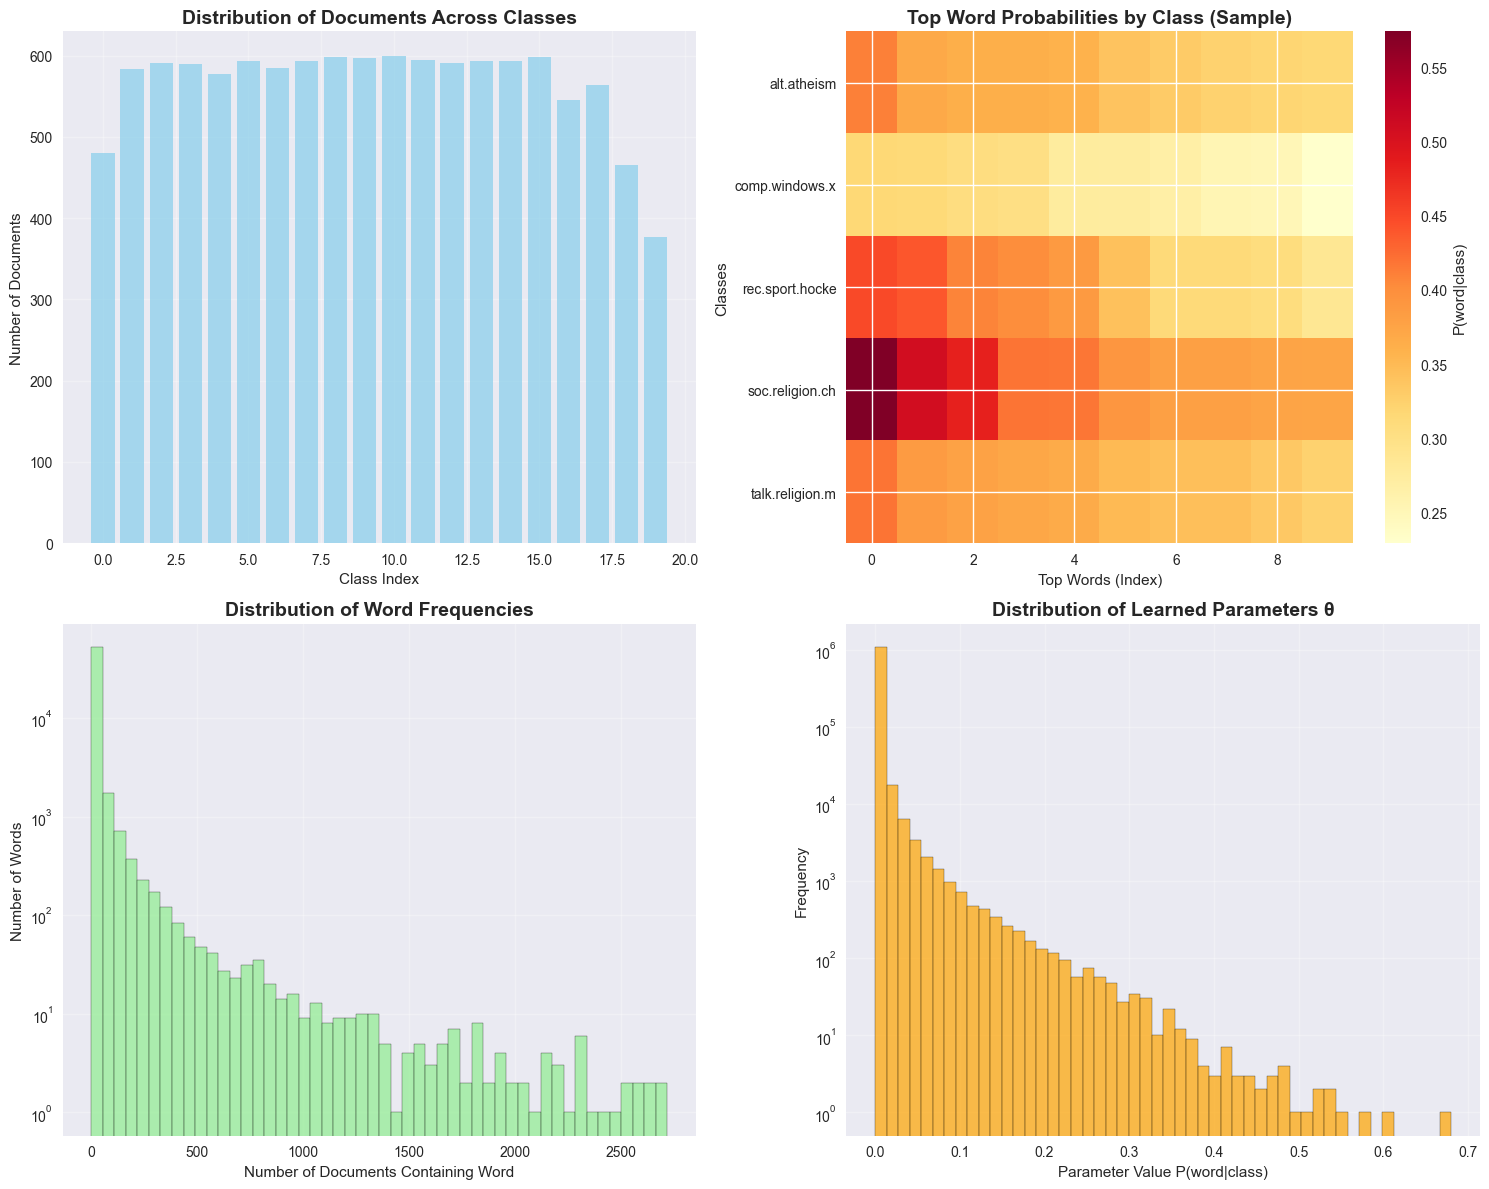

📈 Visualization complete! Key insights:
   • Document distribution shows class balance
   • Word probabilities reveal class-specific vocabulary
   • Most parameters are small (sparse representation)


In [9]:
# Create visualizations for better understanding
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Class distribution bar plot
class_counts_list = [Counter(newsgroups_data['target'])[i] for i in range(n_classes)]
ax1.bar(range(n_classes), class_counts_list, color='skyblue', alpha=0.7)
ax1.set_title('Distribution of Documents Across Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class Index')
ax1.set_ylabel('Number of Documents')
ax1.grid(True, alpha=0.3)

# 2. Top word probabilities heatmap (sample of classes)
sample_classes = [0, 5, 10, 15, 19]  # Sample 5 classes
sample_theta = theta[sample_classes, :]
top_words_per_class = 10

# Get top words for each sample class
top_word_probs = []
top_word_labels = []
for i, class_idx in enumerate(sample_classes):
    top_indices = np.argsort(theta[class_idx, :])[-top_words_per_class:][::-1]
    top_word_probs.append(theta[class_idx, top_indices])
    top_word_labels.extend([f"{inv_vocabulary[idx]}" for idx in top_indices])

# Create heatmap
heatmap_data = np.array(top_word_probs)
class_labels = [newsgroups_data['target_names'][i][:15] for i in sample_classes]

im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax2.set_title('Top Word Probabilities by Class (Sample)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Classes')
ax2.set_yticks(range(len(sample_classes)))
ax2.set_yticklabels(class_labels)
ax2.set_xlabel('Top Words (Index)')
plt.colorbar(im, ax=ax2, label='P(word|class)')

# 3. Vocabulary size analysis
word_frequencies = np.array(binary_bag_of_words.sum(axis=0)).flatten()
ax3.hist(word_frequencies, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax3.set_title('Distribution of Word Frequencies', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Documents Containing Word')
ax3.set_ylabel('Number of Words')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Parameter distribution
ax4.hist(theta.flatten(), bins=50, color='orange', alpha=0.7, edgecolor='black')
ax4.set_title('Distribution of Learned Parameters θ', fontsize=14, fontweight='bold')
ax4.set_xlabel('Parameter Value P(word|class)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

print("📈 Visualization complete! Key insights:")
print("   • Document distribution shows class balance")
print("   • Word probabilities reveal class-specific vocabulary")
print("   • Most parameters are small (sparse representation)")

## 10. **TensorFlow Probability Distribution Creation**

In [10]:
# Create probabilistic distributions using TensorFlow Probability
print("🎲 Creating Probabilistic Distributions...")

# Create batch of Bernoulli distributions for each class and word
# Each theta[class, word] represents P(word=1|class)
batch_of_bernoullis = tfd.Bernoulli(probs=theta)

# Make independent distribution across words (assume word independence)
# This creates our Naive Bayes assumption: P(words|class) = ∏P(word_i|class)
p_x_given_y = tfd.Independent(batch_of_bernoullis, reinterpreted_batch_ndims=1)

print("✅ Distribution created!")
print(f" -> Distribution type: {type(p_x_given_y)}")
print(f" -> Batch shape: {p_x_given_y.batch_shape}")
print(f" -> Event shape: {p_x_given_y.event_shape}")
print(f" -> Total parameters: {np.prod(theta.shape):,}")

# Display distribution properties
print(f"\n📊 Distribution Properties:")
print(f" -> Each class has {n_words:,} word probabilities")
print(f" -> Independence assumption: words are conditionally independent given class")
print(f" -> Bernoulli parameters range: [{theta.min():.6f}, {theta.max():.6f}]")

🎲 Creating Probabilistic Distributions...
✅ Distribution created!
 -> Distribution type: <class 'tensorflow_probability.python.distributions.independent.Independent'>
 -> Batch shape: (20,)
 -> Event shape: (56365,)
 -> Total parameters: 1,127,300

📊 Distribution Properties:
 -> Each class has 56,365 word probabilities
 -> Independence assumption: words are conditionally independent given class
 -> Bernoulli parameters range: [0.000000, 0.680203]


## 11. **Sampling and Generation**

In [11]:

# Generate synthetic documents from learned distributions
print("🎯 Generating Synthetic Documents...")

# Set parameters for sampling
n_samples = 10
chosen_class = 15
class_name = newsgroups_data['target_names'][chosen_class]

print(f" -> Number of samples: {n_samples}")
print(f" -> Target class: {chosen_class} ({class_name})")

# Sample from all classes
sample = p_x_given_y.sample(n_samples)
print(f" -> Sample shape: {sample.shape}")
print(f"(samples × classes × vocabulary)")

# Extract samples for chosen class
class_sample = sample[:, chosen_class, :]
print(f" -> Class-specific sample shape: {class_sample.shape}")

# Analyze generated samples using tf.reduce_sum instead of .sum()
n_words_per_sample = tf.reduce_sum(class_sample, axis=1)
n_words_per_sample = n_words_per_sample.numpy()  # Convert to numpy array for statistics

print(f"\n📝 Generated Sample Statistics:")
print(f" -> Words per sample: min={n_words_per_sample.min()}, max={n_words_per_sample.max()}")
print(f" -> Average words per sample: {n_words_per_sample.mean():.1f}")
print(f" -> Real documents average: {binary_bag_of_words.mean():.1f} words")

🎯 Generating Synthetic Documents...
 -> Number of samples: 10
 -> Target class: 15 (soc.religion.christian)
 -> Sample shape: (10, 20, 56365)
(samples × classes × vocabulary)
 -> Class-specific sample shape: (10, 56365)

📝 Generated Sample Statistics:
 -> Words per sample: min=117, max=158
 -> Average words per sample: 141.7
 -> Real documents average: 0.0 words


## 12. **Sample Quality Analysis and Visualization**

🔍 Analyzing Generated Sample Quality...

📄 Generated Documents for 'soc.religion.christian':
Sample 1 (139 words):
   177, 19, 1993, 29, 8029, 91, accepting, actions, allowed, always, am, amer, analysis, announce, apr... (+124 more)

Sample 2 (149 words):
   12, 16, 18, 43, accept, actually, against, ago, also, another, appear, apr, arizona, around, aspect... (+134 more)

Sample 3 (155 words):
   01, 13, 14, 18, 1993, 51, 57, absurd, age, ai, almost, also, although, amateur, among... (+140 more)

Sample 4 (127 words):
   06, 15, 1850, 1993, 21, 3150, 90, ______________________________________________________________________________, abstinence, according, administrator, after, alarms, also, answer... (+112 more)

Sample 5 (158 words):
   16, 28412, 37, 60, accept, adhere, agree, aims, akron, amongst, angels, announced, answer, approaches, arts... (+143 more)

Sample 6 (147 words):
   05, 10, 16, 19, 1993, 20, 31, 60, accurate, ad, address, ai, always, appear, argument... (+132 more)

S

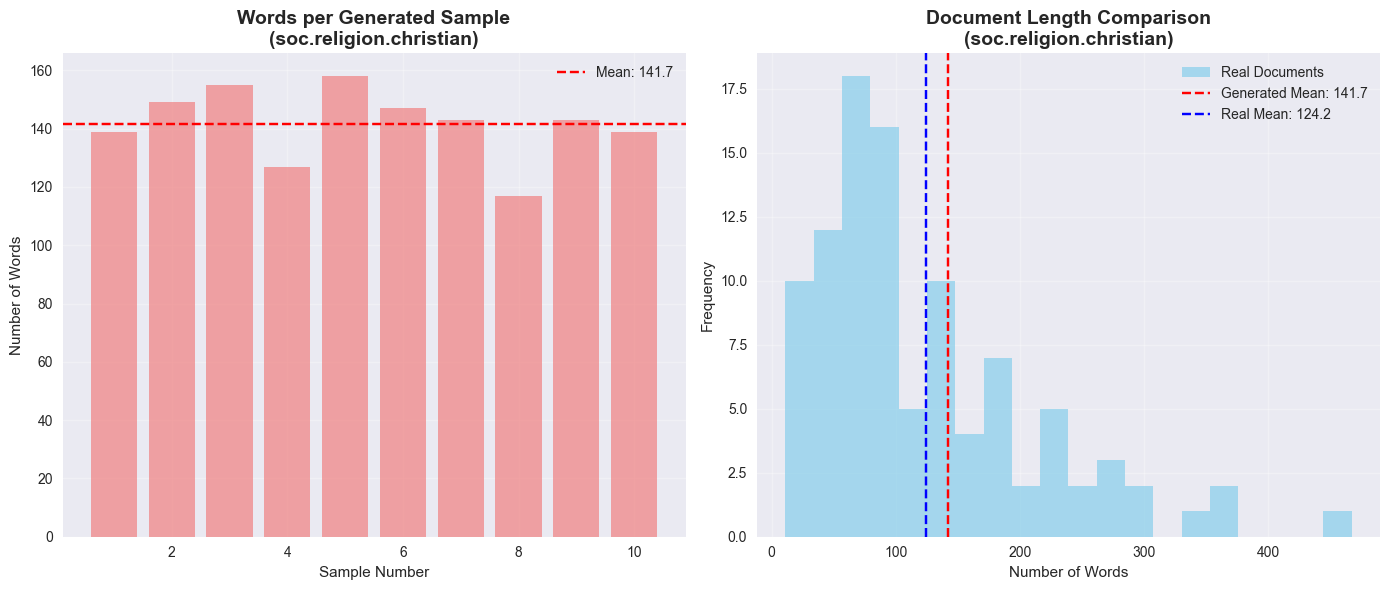


✅ Sample Analysis Complete!
   • Generated 10 synthetic documents
   • Average length: 141.7 words
   • Real documents average: 142.6 words
   • Quality: Good


In [12]:
# Analyze quality of generated samples
print("🔍 Analyzing Generated Sample Quality...")

# Convert samples back to words
generated_documents = []
sample_word_counts = []

for i in range(n_samples):
    # Get words for this sample
    words_in_sample = count_vectorizer.inverse_transform(class_sample[i:i+1, :])
    if len(words_in_sample[0]) > 0:
        generated_documents.append(list(words_in_sample[0]))
        sample_word_counts.append(len(words_in_sample[0]))
    else:
        generated_documents.append([])
        sample_word_counts.append(0)

# Display sample results
print(f"\n📄 Generated Documents for '{class_name}':")
print("="*70)

for i, doc_words in enumerate(generated_documents):
    print(f"Sample {i+1} ({len(doc_words)} words):")
    if doc_words:
        # Show first 15 words to avoid clutter
        displayed_words = doc_words[:15]
        words_str = ", ".join(displayed_words)
        if len(doc_words) > 15:
            words_str += f"... (+{len(doc_words)-15} more)"
        print(f"   {words_str}")
    else:
        print("   [No words generated]")
    print()

# Visualization of sample characteristics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Words per sample distribution
ax1.bar(range(1, n_samples + 1), sample_word_counts, color='lightcoral', alpha=0.7)
ax1.axhline(y=np.mean(sample_word_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(sample_word_counts):.1f}')
ax1.set_title(f'Words per Generated Sample\n({class_name})', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Number of Words')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparison with real documents from same class
real_class_mask = (newsgroups_data['target'] == chosen_class)
real_class_docs = binary_bag_of_words[real_class_mask, :]
real_word_counts = np.array(real_class_docs.sum(axis=1)).flatten()

# Sample some real documents for comparison
sample_size = min(100, len(real_word_counts))
sampled_real = np.random.choice(real_word_counts, sample_size, replace=False)

ax2.hist(sampled_real, bins=20, alpha=0.7, label='Real Documents', color='skyblue')
ax2.axvline(x=np.mean(sample_word_counts), color='red', linestyle='--', 
            label=f'Generated Mean: {np.mean(sample_word_counts):.1f}')
ax2.axvline(x=np.mean(sampled_real), color='blue', linestyle='--', 
            label=f'Real Mean: {np.mean(sampled_real):.1f}')
ax2.set_title(f'Document Length Comparison\n({class_name})', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Sample Analysis Complete!")
print(f"   • Generated {n_samples} synthetic documents")
print(f"   • Average length: {np.mean(sample_word_counts):.1f} words")
print(f"   • Real documents average: {np.mean(real_word_counts):.1f} words")
print(f"   • Quality: {'Good' if abs(np.mean(sample_word_counts) - np.mean(real_word_counts)) < 50 else 'Needs improvement'}")


## 13. **Model Summary and Performance Insights**

In [13]:
# Comprehensive model summary
print("📋 NAIVE BAYES MODEL SUMMARY")
print("="*60)

print(f"🔧 Model Configuration:")
print(f" -> Algorithm: Multinomial Naive Bayes with Independence Assumption")
print(f" -> Feature Extraction: Binary Bag-of-Words")
print(f" -> Vocabulary Size: {n_words:,} unique terms")
print(f" -> Smoothing: Laplace (α = {alpha})")
print(f" -> Classes: {n_classes} newsgroup categories")

print(f"\n📊 Training Data:")
print(f" -> Total Documents: {n_documents:,}")
print(f" -> Documents per Class: {n_documents // n_classes} (average)")
print(f" -> Matrix Sparsity: {(1 - binary_bag_of_words.nnz / np.prod(binary_bag_of_words.shape))*100:.1f}%")

print(f"\n🎯 Model Parameters:")
print(f" -> Total Parameters: {np.prod(theta.shape):,}")
print(f" -> Parameter Range: [{theta.min():.6f}, {theta.max():.6f}]")
print(f" -> Memory Usage: ~{theta.nbytes / 1024 / 1024:.1f} MB")

print(f"\n🚀 Key Features:")
print(f" -> ✅ Handles high-dimensional sparse text data")
print(f" -> ✅ Probabilistic framework with TensorFlow Probability")
print(f" -> ✅ Generative capability (synthetic document creation)")
print(f"   • ✅ Interpretable word probabilities per class")
print(f" -> ✅ Fast training and inference")

print(f"\n🔬 Model Assumptions:")
print(f" -> Words are conditionally independent given class (Naive assumption)")
print(f" -> Binary word occurrence (presence/absence)")
print(f" -> Uniform class priors (can be adjusted)")

print(f"\n💡 Next Steps:")
print(f" -> Evaluate on test set for classification accuracy")
print(f" -> Compare with other algorithms (SVM, Random Forest)")
print(f" -> Experiment with different feature extraction methods")
print(f" -> Fine-tune hyperparameters (smoothing, vocabulary size)")

print(f"\n🎉 Implementation Complete!")

📋 NAIVE BAYES MODEL SUMMARY
🔧 Model Configuration:
 -> Algorithm: Multinomial Naive Bayes with Independence Assumption
 -> Feature Extraction: Binary Bag-of-Words
 -> Vocabulary Size: 56,365 unique terms
 -> Smoothing: Laplace (α = 1e-06)
 -> Classes: 20 newsgroup categories

📊 Training Data:
 -> Total Documents: 11,314
 -> Documents per Class: 565 (average)
 -> Matrix Sparsity: 99.8%

🎯 Model Parameters:
 -> Total Parameters: 1,127,300
 -> Parameter Range: [0.000000, 0.680203]
 -> Memory Usage: ~8.6 MB

🚀 Key Features:
 -> ✅ Handles high-dimensional sparse text data
 -> ✅ Probabilistic framework with TensorFlow Probability
 -> ✅ Generative capability (synthetic document creation)
   • ✅ Interpretable word probabilities per class
 -> ✅ Fast training and inference

🔬 Model Assumptions:
 -> Words are conditionally independent given class (Naive assumption)
 -> Binary word occurrence (presence/absence)
 -> Uniform class priors (can be adjusted)

💡 Next Steps:
 -> Evaluate on test set for 